# Кочетков Максим ШАД-412. Генератор художественного текста на основе архитектуры Трансформер

## Зависимости и настройки

In [ ]:
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from typing import List

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import time
import re

In [5]:
device = torch.device(
    'cuda'
    if torch.cuda.is_available()
    else 'cpu'
)

device

device(type='cuda')

## Подготовка текстовых корпусов

In [6]:
def read_corpus(path: str) -> str:
    """
    Функция для получения корпуса текста из файла.
    
    :param path: путь до файла с данными.

    :return: первичный корпус текста.
    """
    with open(path, 'r', encoding='utf-8') as f:
        corpus = f.read()

    return corpus.replace('\r', '')

In [7]:
class CharDataset(Dataset):
    def __init__(self, seq: torch.Tensor, block_size: int):
        self.seq = seq
        self.bs = block_size

    def __len__(self):
        return max(1, len(self.seq) - self.bs)

    def __getitem__(self, idx):
        x = self.seq[idx:idx + self.bs]
        y = self.seq[idx + 1:idx + self.bs + 1]
        return x, y

In [8]:
def make_dataloader(
    data: torch.Tensor,
    block_size: int,
    batch_size: int,
) -> DataLoader:
    block_size = min(block_size, len(data) - 1)
    dataset = CharDataset(data, block_size=block_size)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    return loader

In [ ]:
def char_ngrams(text: str, n: int = 2):
    """
    Формирует символьные n-граммы.

    :param text:
    :param n: 

    :return: список символов или n-грамм
    """
    if n <= 1:
        return list(text)

    return [
        text[i:i+n]
        for i in range(len(text) - n + 1)
    ]

In [9]:
def detokenize_char_ngrams(tokens: List[str]):
    """
    Формирует представление текста из токенов

    :param tokens: токены

    :return: представление текста.
    """

    if not tokens:
        return ""

    s = tokens[0]
    for tok in tokens[1:]:
        s += tok[-1]
    return s

In [10]:
def build_vocab_and_data(text: str, ngram_n: int = 1):
    """
    Переводит текстовые данные в численное представление.

    :param text: текстовый корпус
    :param ngram_n: размер n-грамм

    :return: (
        Соотношение индексов к символам,
        Соотношение символов к индексам,
        Числовое представление данных,
        Размер словаря (Количество токенов)
    )
    """
    if ngram_n == 1:
        tokens = list(text)
    else:
        tokens = char_ngrams(text, ngram_n)

    vocab = sorted(list(set(tokens)))
    itos = {i: tok for i, tok in enumerate(vocab)}
    stoi = {tok: i for i, tok in itos.items()}
    data = torch.tensor([stoi[tok] for tok in tokens], dtype=torch.long)
    vocab_size = len(vocab)
    return itos, stoi, data, vocab_size


def prepare_text(
    path: str,
    block_size: int = 64,
    batch_size: int = 16,
    ngram_n: int = 1,
):
    text = read_corpus(path)
    itos, stoi, data, vocab_size = build_vocab_and_data(text, ngram_n=ngram_n)
    loader = make_dataloader(data, block_size, batch_size)
    return itos, stoi, data, loader, vocab_size

## Реализация структурных блоков Трансформера

In [12]:
class PositionalEncoding(nn.Module):

    """
    Добавляет позиционное (sin/cos) кодирование к эмбеддингам.

    :param d_model: размерность эмбеддинга.
    :param max_len: максимальное количество токенов.
    """

    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()

        positional_encoding = torch.zeros(
            max_len, d_model
        )

        positions = torch.arange(
            0,
            max_len,
            dtype=torch.float
        ).unsqueeze(1)

        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-np.log(10000.0) / d_model)
        )

        positional_encoding[:, 0::2] = torch.sin(positions * div_term)
        positional_encoding[:, 1::2] = torch.cos(positions * div_term)

        self.positional_encoding = positional_encoding.unsqueeze(0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        """
        Применяет позиционное кодирование к входному тензору.
        
        :param x: входной тензор размерности (batch_size, seq_len, d_model)

        :return: тензор с добавленным позиционным кодированием
        """

        seq_len = x.size(1)
        return x + self.positional_encoding[:, :seq_len].to(x.device)

In [13]:
class MultiHeadSelfAttention(nn.Module):

    """
    Реализует параллельное вычисление внимания через несколько голов для
    захвата различных аспектов зависимостей в последовательности.

    :param d_model: размерность входных эмбеддингов
    :param num_heads: количество голов внимания
    :param dropout: вероятность dropout для матрицы внимания
    :param masked: если True, применяется маскированное self-attention
    """

    def __init__(
        self,
        d_model: int,
        num_heads: int,
        dropout: float = 0.1,
        masked: bool = False
    ):

        super().__init__()
        assert d_model % num_heads == 0, 'd_model должно делиться на num_heads без остатка'

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.masked = masked

        self.W_Q = nn.Linear(d_model, d_model, bias=False)
        self.W_K = nn.Linear(d_model, d_model, bias=False)
        self.W_V = nn.Linear(d_model, d_model, bias=False)

        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def _split_heads(self, x: torch.Tensor) -> torch.Tensor:

        """
        Разделяет эмбеддинги на несколько голов.
        
        :param x: входной тензор (batch_size, seq_len, d_model)

        :return: тензор (batch_size, num_heads, seq_len, head_dim)
        """

        batch_size, seq_len, _ = x.size()
        x = x.view(batch_size, seq_len, self.num_heads, self.head_dim)
        x = x.transpose(1, 2)
        return x

    def _combine_heads(self, x: torch.Tensor) -> torch.Tensor:

        """
        Объединяет результаты из всех голов обратно в один тензор.
        
        :param x: тензор (batch_size, num_heads, seq_len, head_dim)

        :return: тензор (batch_size, seq_len, d_model)
        """

        batch_size, _, seq_len, _ = x.size()
        x = x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        return x

    def _make_causal_mask(self, seq_len: int, device: torch.device) -> torch.Tensor:
    
        """
        Создает маску для предотвращения внимания к будущим позициям.
        
        :param seq_len: длина последовательности
        :param device: устройство для размещения маски

        :return: нижнетреугольная маска (1, 1, seq_len, seq_len)
        """

        mask = torch.tril(torch.ones(seq_len, seq_len, device=device)).bool()
        return mask.unsqueeze(0).unsqueeze(0)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:

        """
        Применяет механизм многоголового самовнимания к входной последовательности.
        
        :param x: входной тензор (batch_size, seq_len, d_model)
        :param mask: опциональная маска внимания

        :return: выходной тензор (batch_size, seq_len, d_model)
        """

        batch_size, seq_len, _ = x.size()

        q = self.W_Q(x)
        k = self.W_K(x)
        v = self.W_V(x)

        q = self._split_heads(q)
        k = self._split_heads(k)
        v = self._split_heads(v)

        scores = torch.matmul(
            q, k.transpose(-2, -1)
        ) / np.sqrt(self.head_dim)

        if self.masked and mask is None:
            mask = self._make_causal_mask(seq_len, x.device)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)

        out = self._combine_heads(out)

        return self.out_proj(out)

In [14]:
class FeedForward(nn.Module):

    """
    FFN для нелинейного преобразования представлений
    после словя внимания.

    :param model_size: размерность входных и выходных эмбеддингов
    :param hidden_size: размерность скрытого слоя
    :param dropout: вероятность dropout для регуляризации
    """

    def __init__(self, model_size, hidden_size, dropout=0.1):
        super().__init__()
    
        self.feed_forward = nn.Sequential(
            nn.Linear(model_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, model_size),
        )

    def forward(self, x):
        return self.feed_forward(x)

In [15]:
class DecoderLayer(nn.Module):

    """
    Один блок декодера трансформера.
    
    Содержит маскированный self-attention, позиционную нормализацию и
    двухслойную FFN с остаточными связями.

    :param d_model: размерность эмбеддингов.
    :param num_heads: количество голов внимания в self-attention
    :param d_ff: размер скрытого слоя в feed-forward сети
    :param dropout: вероятность dropout для регуляризации
    """

    def __init__(
        self,
        d_model: int,
        num_heads: int,
        d_ff: int,
        dropout: float = 0.1,
    ):
        super().__init__()

        self.self_attn = MultiHeadSelfAttention(
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            masked=True,
        )

        self.ff = FeedForward(
            model_size=d_model,
            hidden_size=d_ff,
            dropout=dropout,
        )

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        x: torch.Tensor,
        mask: torch.Tensor = None,
    ) -> torch.Tensor:

        """
        Пропускает последовательность через слой декодера.
        
        :param x: входной тензор (batch_size, seq_len, d_model)
        :param mask: маска внимания для self-attention
        :return: обработанный тензор (batch_size, seq_len, d_model)
        """

        attn_out = self.self_attn(x, mask=mask)
        x = self.norm1(x + self.dropout(attn_out))

        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))

        return x

## Реализация модели

In [16]:
class DecoderOnlyTransformer(nn.Module):

    """
    Decoder-only трансформер для генерации текста.
    
    Генерирует текст последовательно, токен за токеном, используя только
    предыдущие токены без доступа к будущим.

    :param vocab_size: размер словаря токенов
    :param d_model: размерность эмбеддингов
    :param n_layers: количество decoder-слоёв
    :param n_heads: количество голов внимания
    :param d_ff: размер скрытого слоя в FFN
    :param max_len: максимальная длина последовательности
    :param dropout: вероятность dropout
    :param block_size: размер контекстного окна при генерации
    """

    def __init__(
        self,
        vocab_size: int,
        d_model: int = 128,
        n_layers: int = 4,
        n_heads: int = 4,
        d_ff: int = 512,
        max_len: int = 512,
        dropout: float = 0.1,
        block_size: int = 512,
    ):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.block_size = block_size

        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=max_len)

        self.layers = nn.ModuleList(
            [
                DecoderLayer(
                    d_model=d_model,
                    num_heads=n_heads,
                    d_ff=d_ff,
                    dropout=dropout,
                )
                for _ in range(n_layers)
            ]
        )

        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(
            d_model,
            vocab_size,
            bias=False
        )

        self.head.weight = self.tok_emb.weight

    def _causal_mask(self, S: int, device: torch.device) -> torch.Tensor:

        """
        Создает маску для предотвращения внимания к будущим токенам.
        
        :param S: длина последовательности
        :param device: устройство для размещения маски
        :return: нижнетреугольная маска (1, 1, S, S)
        """

        mask = torch.tril(
            torch.ones((S, S), dtype=torch.bool, device=device)
        )
        return mask.unsqueeze(0).unsqueeze(0)

    def forward(self, idx: torch.Tensor) -> torch.Tensor:

        """
        Вычисляет логиты предсказаний для каждой позиции.
        
        :param idx: индексы токенов (batch_size, seq_len)
        :return: логиты (batch_size, seq_len, vocab_size)
        """

        B, S = idx.size()

        x = self.tok_emb(idx) * np.sqrt(self.tok_emb.embedding_dim)
        x = self.pos_enc(x)

        mask = self._causal_mask(S, x.device)

        for layer in self.layers:
            x = layer(x, mask=mask)

        x = self.ln_f(x)
        logits = self.head(x)
        return logits

    @torch.no_grad()
    def generate(
        self,
        idx: torch.Tensor,
        max_new_tokens: int = 100,
        temperature: float = 1.0,
    ) -> torch.Tensor:

        """
        Генерирует новые токены на основе начальной последовательности.
        
        :param idx: начальная последовательность (batch_size, start_seq_len)
        :param max_new_tokens: количество токенов для генерации
        :param temperature: температура сэмплирования (выше = более случайно)
        :return: расширенная последовательность (batch_size, start_seq_len + max_new_tokens)
        """

        self.eval()
        block_size = self.block_size

        for _ in range(max_new_tokens):
            if idx.size(1) > block_size:
                idx_cond = idx[:, -block_size:]
            else:
                idx_cond = idx

            logits = self.forward(idx_cond)

            logits_last = logits[:, -1, :]

            if temperature > 0:
                logits_last = logits_last / temperature

            probs = F.softmax(logits_last, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            idx = torch.cat([idx, next_token], dim=1)

        return idx

## Обучение

Получение словаря

In [17]:
itos, stoi, data, loader, vocab_size = prepare_text(
    path='onegin_text.txt',
    block_size=64,
    batch_size=16,
    ngram_n=2
)

Объявление модели и оптимизатора

In [18]:
model = DecoderOnlyTransformer(
    vocab_size=vocab_size,
    d_model=128,
    n_layers=3,
    n_heads=4,
    d_ff=512,
    max_len=512,
    dropout=0.1,
    block_size=64,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

Обучение модели

In [19]:
epochs = 120
history_loss = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0
    cnt = 0
    t0 = time.time()

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model(xb)

        loss = criterion(
            logits.view(-1, vocab_size),
            yb.view(-1),
        )

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        cnt += 1

    avg_loss = total_loss / cnt
    history_loss.append(avg_loss)

    print(
        f"Epoch {epoch:2d}  "
        f"loss {avg_loss:.4f}  "
        f"time {time.time() - t0:.2f}s"
    )

torch.save(model.state_dict(), "model_last_epoch.pth")

Epoch  1  loss 2.4475  time 75.40s
Epoch  2  loss 1.8288  time 74.28s
Epoch  3  loss 1.6812  time 75.15s
Epoch  4  loss 1.5863  time 73.80s
Epoch  5  loss 1.5170  time 73.84s
Epoch  6  loss 1.4628  time 74.11s
Epoch  7  loss 1.4166  time 74.71s
Epoch  8  loss 1.3766  time 75.21s
Epoch  9  loss 1.3410  time 76.90s
Epoch 10  loss 1.3082  time 75.08s
Epoch 11  loss 1.2782  time 74.09s
Epoch 12  loss 1.2503  time 73.99s
Epoch 13  loss 1.2236  time 74.43s
Epoch 14  loss 1.1994  time 74.31s
Epoch 15  loss 1.1759  time 73.95s
Epoch 16  loss 1.1541  time 73.73s
Epoch 17  loss 1.1334  time 74.64s
Epoch 18  loss 1.1142  time 75.27s
Epoch 19  loss 1.0951  time 75.48s
Epoch 20  loss 1.0772  time 75.04s
Epoch 21  loss 1.0608  time 75.04s
Epoch 22  loss 1.0449  time 76.50s
Epoch 23  loss 1.0305  time 74.90s
Epoch 24  loss 1.0165  time 75.00s
Epoch 25  loss 1.0037  time 74.97s
Epoch 26  loss 0.9923  time 75.27s
Epoch 27  loss 0.9802  time 74.92s
Epoch 28  loss 0.9701  time 74.70s
Epoch 29  loss 0.959

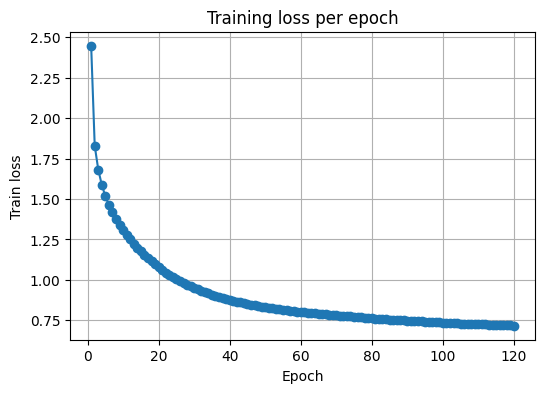

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(history_loss) + 1), history_loss, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.title("Training loss per epoch")
plt.grid(True)
plt.show()

## Генерация

In [ ]:
def generate_text(
    model,
    itos,
    stoi,
    device,
    seed: str = "Евгений Онегин",
    max_new_tokens: int = 120,
    temperature: float = 1.0,
    ngram_n: int = 1,
):
    """
    Генерация текста.

    :param model: decoder-only трансформер
    :param itos: индекс-токен словарь
    :param stoi: токен-индекс словарь
    :param device: устройство для вычислений
    :param seed: начальный текст, от которого продолжается генерация
    :param max_new_tokens: максимальное число генерируемых токенов
    :param temperature: температура сэмплирования (выше — более случайный текст)
    :param ngram_n: 1 — посимвольная модель, > 1 — модель на символьных n-граммах
    :return: сгенерированный текст как строка
    """
    model.eval()

    if ngram_n == 1:
        seed_tokens = list(seed)
    else:
        seed_tokens = char_ngrams(seed, ngram_n)

    seed_ids = [stoi.get(tok, 0) for tok in seed_tokens]

    idx = torch.tensor(
        [seed_ids],
        dtype=torch.long,
        device=device,
    )

    out_idx = model.generate(
        idx,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
    )[0].tolist()

    tokens = [itos[i] for i in out_idx]

    if ngram_n == 1:
        text = ''.join(tokens)
    else:
        text = detokenize_char_ngrams(tokens, ngram_n)

    return text

Пример генерации

In [22]:
text = generate_text(
    model,
    itos=itos,
    stoi=stoi,
    device=device,
    seed='Евгений Онегин',
    max_new_tokens=40,
    temperature=0.7,
    ngram_n=2,
)

print('ВЫВОД: \n')
print(text)

ВЫВОД: 

Евгений Онегин пора
Себят кончался.
— Давно дно, он зд


## Оценка качества

In [23]:
def build_corpus_stats(text: str, n: int = 2) -> dict:

    """
    Собирает статистику по корпусу текста: частоты символов и множество n-грамм.
    
    :param text: текстовый корпус для анализа
    :param n: размер n-грамм
    :return: словарь со статистикой:
        - char_freq: частоты каждого символа (нормированные)
        - ngrams: множество всех уникальных n-грамм в тексте
        - n: размер n-грамм
        - text: исходный текст
    """

    cnt = Counter(text)
    total = sum(cnt.values()) or 1
    char_freq = {ch: c / total for ch, c in cnt.items()}

    ngrams = set()
    if len(text) >= n:
        for i in range(len(text) - n + 1):
            ngrams.add(text[i:i+n])

    return {
        "char_freq": char_freq,
        "ngrams": ngrams,
        "n": n,
        "text": text,
    }

corpus_text = read_corpus('/kaggle/input/nn-course-2025/тексты_для_нейронки/onegin_text.txt')
corpus_stats = build_corpus_stats(corpus_text, n=2)

In [24]:
def char_freq_distance(text: str, corpus_char_freq: dict) -> float:
    """
    Вычисляет евклидово расстояние между частотами символов в тексте и корпусе.
    
    Метрика показывает, насколько распределение символов в сгенерированном тексте
    отличается от исходного корпуса. Чем меньше значение, тем ближе текст к корпусу.
    
    :param text: анализируемый текст
    :param corpus_char_freq: словарь частот символов корпуса

    :return: евклидово-расстояние между распределениями частот
    """

    cnt = Counter(text)
    total = sum(cnt.values()) or 1
    dist_sq = 0.0
    for ch, p_corpus in corpus_char_freq.items():
        p_text = cnt.get(ch, 0) / total
        dist_sq += (p_text - p_corpus) ** 2
    return np.sqrt(dist_sq)


def unseen_ngram_ratio(text: str, corpus_ngrams: set, n: int) -> float:

    """
    Вычисляет долю новых n-грамм, которых не было в обучающем корпусе.
    
    0.0 — все n-граммы взяты из корпуса (копирование)
    1.0 — все n-граммы новые
    
    :param text: анализируемый текст
    :param corpus_ngrams: множество n-грамм из обучающего корпуса
    :param n: размер n-грамм

    :return: доля новых n-грамм
    """

    if len(text) < n:
        return 1.0
    total = 0
    unseen = 0
    for i in range(len(text) - n + 1):
        ng = text[i:i+n]
        total += 1
        if ng not in corpus_ngrams:
            unseen += 1
    return unseen / total if total > 0 else 1.0


def longest_common_substring_len(s1: str, s2: str) -> int:

    """
    Находит длину самой длинной общей подстроки между двумя строками.
    
    Использует динамическое программирование для поиска максимального
    непрерывного совпадения символов между s1 и s2.
    
    :param s1: первая строка
    :param s2: вторая строка

    :return: длина наибольшей общей подстроки
    """

    m, n = len(s1), len(s2)
    dp = [0] * (n + 1)
    best = 0
    for i in range(1, m + 1):
        prev = 0
        for j in range(1, n + 1):
            tmp = dp[j]
            if s1[i-1] == s2[j-1]:
                dp[j] = prev + 1
                if dp[j] > best:
                    best = dp[j]
            else:
                dp[j] = 0
            prev = tmp
    return best

def eval_generated(text: str, corpus_stats: dict) -> dict:

    """
    Считает метрики по сгенерированному моделью тексту

    :param text: сгенерированный текст
    :param corpus_stats: предрассчитанные статистики для исходного корпуса

    :return: значение метрик
    """
    
    char_dist = char_freq_distance(
        text,
        corpus_stats["char_freq"]
    )
    unseen_ratio = unseen_ngram_ratio(
        text,
        corpus_stats["ngrams"],
        corpus_stats["n"],
    )
    lcs_len = longest_common_substring_len(
        text,
        corpus_stats["text"]
    )

    lcs_ratio = lcs_len / max(1, len(text))

    return {
        "char_freq_l2": char_dist,
        "unseen_ngram_ratio": unseen_ratio,
        "lcs_len": lcs_len,
        "lcs_ratio": lcs_ratio,
    }

In [25]:
def sweep_t_and_length(
    model,
    itos,
    stoi,
    device,
    corpus_stats: dict,
    seed: str = "Евгений Онегин",
    ngram_n: int = 1,
    t_min: float = 0.0,
    t_max: float = 1.0,
    t_step: float = 0.1,
    len_step: int = 120,
    len_max: int = 1080,
):

    """
    Выполняет перебор параметров генерации (температура и длина) и оценивает качество текста.
    
    Для каждой комбинации температуры и длины генерирует текст и вычисляет метрики
    качества, сохраняя результаты в DataFrame для последующего анализа.
    
    :param model: обученная модель для генерации
    :param itos: словарь индекс-токен
    :param stoi: словарь токен-индекс
    :param device: устройство для вычислений
    :param corpus_stats: статистика корпуса для оценки метрик
    :param seed: начальный текст для генерации
    :param ngram_n: размер n-грамм (1 — символы, >1 — n-граммы)
    :param t_min: минимальная температура
    :param t_max: максимальная температура
    :param t_step: шаг изменения температуры
    :param len_step: шаг изменения длины генерации
    :param len_max: максимальная длина генерации
    :return: DataFrame с результатами (температура, длина, метрики)
    """

    results = []

    temps = np.arange(t_min, t_max + 1e-8, t_step)
    lengths = list(range(len_step, len_max + 1, len_step))

    for T in temps:
        for L in lengths:
            text = generate_text(
                model,
                itos=itos,
                stoi=stoi,
                device=device,
                seed=seed,
                max_new_tokens=L,
                temperature=T,
                ngram_n=ngram_n,
            )

            metrics = eval_generated(text, corpus_stats)

            results.append({
                "temperature": T,
                "length": L,
                **metrics,
            })

            print(
                f"T={T:.1f}, L={L}: "
                f"char_l2={metrics['char_freq_l2']:.4f}, "
                f"unseen={metrics['unseen_ngram_ratio']:.4f}, "
                f"lcs_ratio={metrics['lcs_ratio']:.4f}"
            )

    df = pd.DataFrame(results)
    return df


df_metrics = sweep_t_and_length(
    model,
    itos=itos,
    stoi=stoi,
    device=device,
    corpus_stats=corpus_stats,
    seed="Евгений Онегин",
    ngram_n=2,
    t_min=0.0,
    t_max=1.0,
    t_step=0.1,
    len_step=120,
    len_max=1080,
)

T=0.0, L=120: char_l2=0.1191, unseen=0.1835, lcs_ratio=0.0261
T=0.0, L=240: char_l2=0.0786, unseen=0.2130, lcs_ratio=0.0138
T=0.0, L=360: char_l2=0.0560, unseen=0.2209, lcs_ratio=0.0094
T=0.0, L=480: char_l2=0.0474, unseen=0.2168, lcs_ratio=0.0071
T=0.0, L=600: char_l2=0.0492, unseen=0.2021, lcs_ratio=0.0057
T=0.0, L=720: char_l2=0.0356, unseen=0.2011, lcs_ratio=0.0048
T=0.0, L=840: char_l2=0.0264, unseen=0.2080, lcs_ratio=0.0041
T=0.0, L=960: char_l2=0.0329, unseen=0.2121, lcs_ratio=0.0036
T=0.0, L=1080: char_l2=0.0209, unseen=0.2181, lcs_ratio=0.0032
T=0.1, L=120: char_l2=0.1366, unseen=0.1723, lcs_ratio=0.0261
T=0.1, L=240: char_l2=0.0758, unseen=0.1933, lcs_ratio=0.0138
T=0.1, L=360: char_l2=0.0670, unseen=0.1928, lcs_ratio=0.0094
T=0.1, L=480: char_l2=0.0596, unseen=0.1895, lcs_ratio=0.0071
T=0.1, L=600: char_l2=0.0396, unseen=0.2160, lcs_ratio=0.0057
T=0.1, L=720: char_l2=0.0368, unseen=0.1997, lcs_ratio=0.0048
T=0.1, L=840: char_l2=0.0411, unseen=0.2203, lcs_ratio=0.0041
T=0.1, 

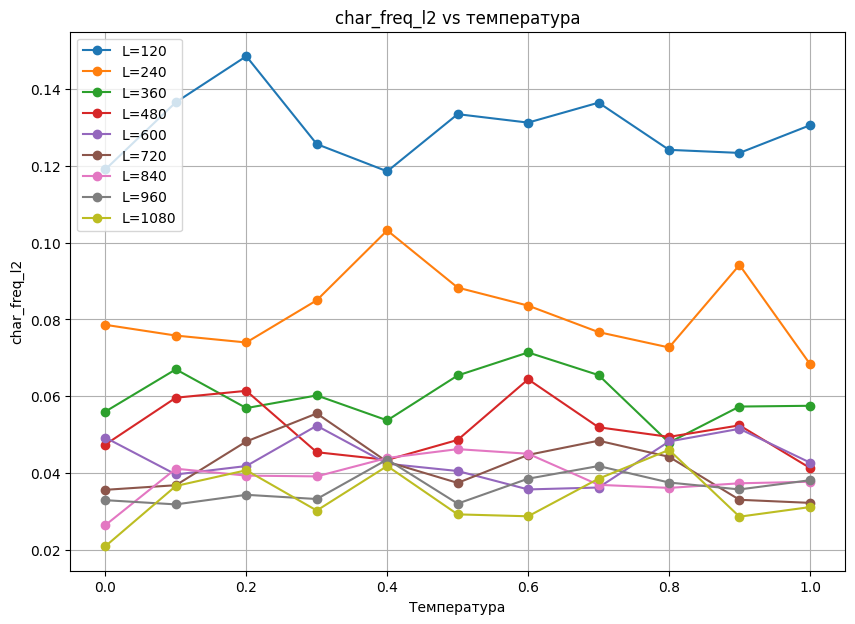

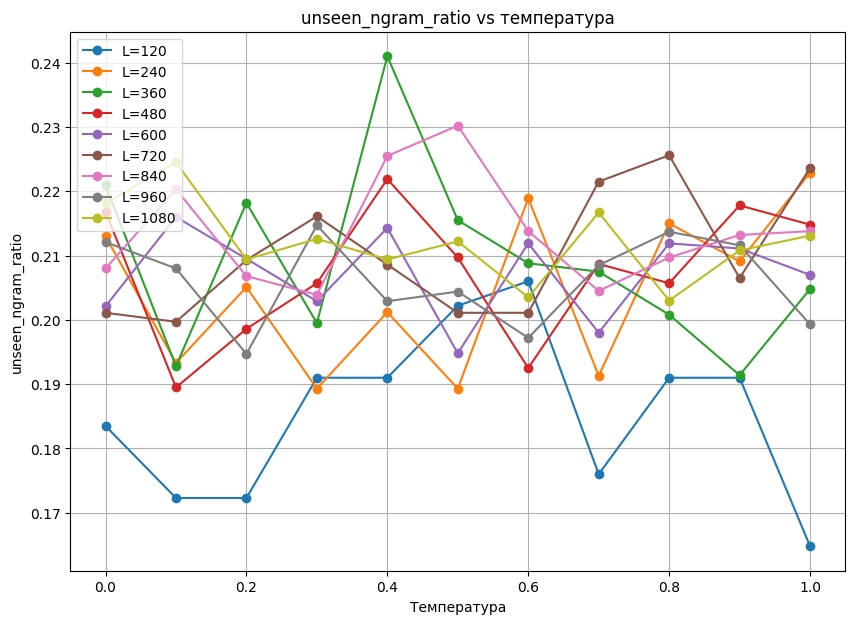

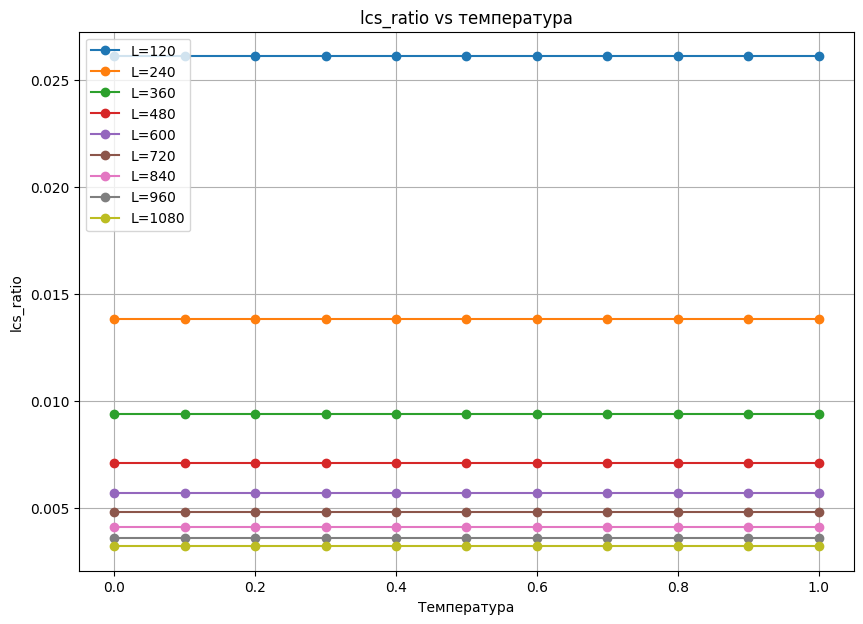

In [9]:
def plot_metric_vs_temperature(df, metric: str):
    plt.figure(figsize=(10, 7))
    for L in sorted(df["length"].unique()):
        sub = df[df["length"] == L].sort_values("temperature")
        plt.plot(sub["temperature"], sub[metric], marker='o', label=f"L={L}")
    plt.xlabel("Температура")
    plt.ylabel(metric)
    plt.title(f"{metric} vs температура")
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()

plot_metric_vs_temperature(df_metrics, "char_freq_l2")
plot_metric_vs_temperature(df_metrics, "unseen_ngram_ratio")
plot_metric_vs_temperature(df_metrics, "lcs_ratio")

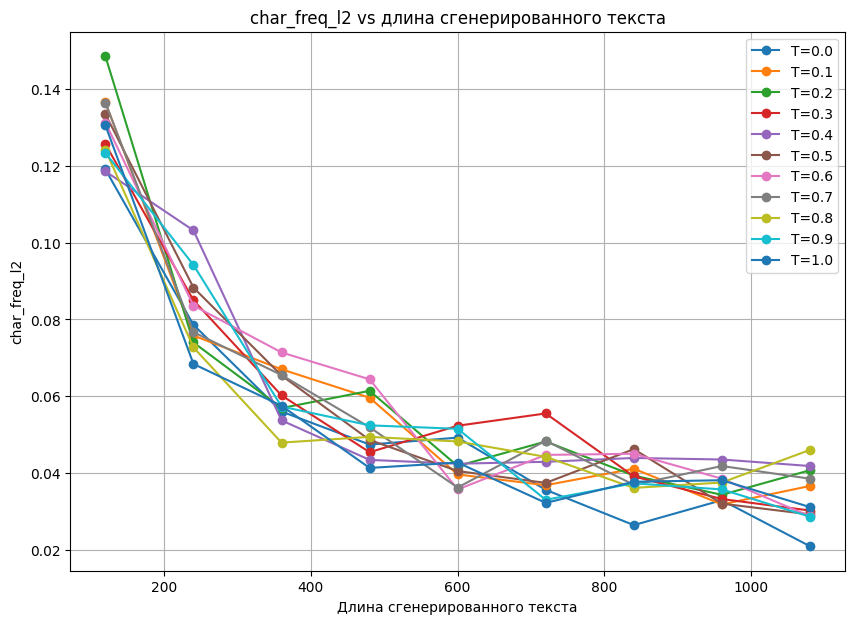

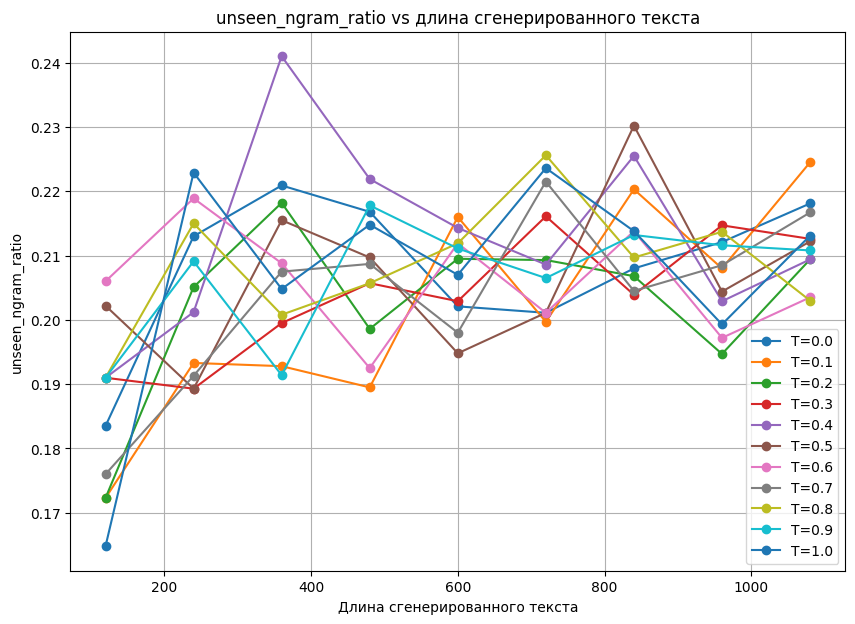

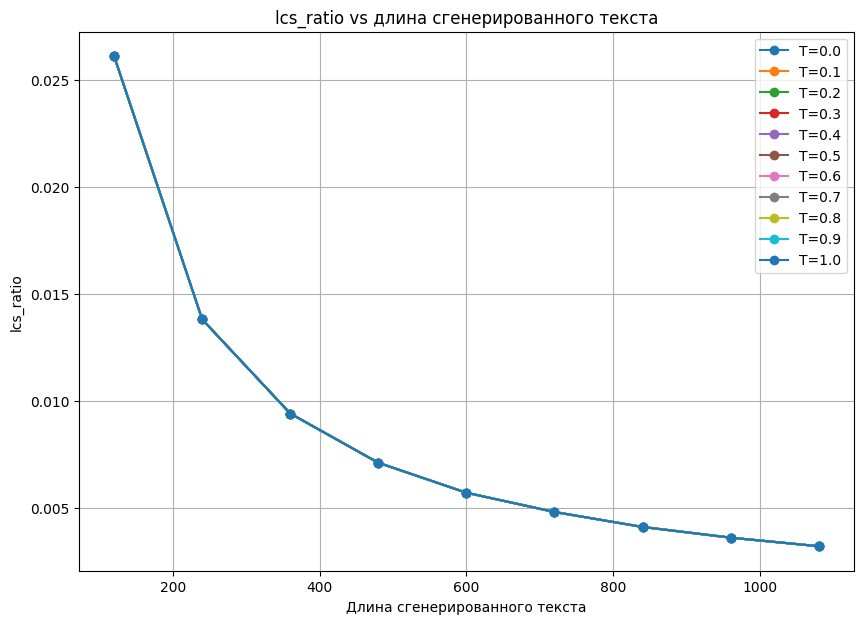

In [12]:
def plot_metric_vs_length(df, metric: str):
    plt.figure(figsize=(10, 7))
    for T in sorted(df["temperature"].unique()):
        sub = df[np.isclose(df["temperature"], T)].sort_values("length")
        plt.plot(sub["length"], sub[metric], marker='o', label=f"T={T:.1f}")
    plt.xlabel("Длина сгенерированного текста")
    plt.ylabel(metric)
    plt.title(f"{metric} vs длина сгенерированного текста")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_metric_vs_length(df_metrics, "char_freq_l2")
plot_metric_vs_length(df_metrics, "unseen_ngram_ratio")
plot_metric_vs_length(df_metrics, "lcs_ratio")